# Sources

# Imports

In [1]:
import torch, sys, os, time
import dill as pickle
import torch.nn as nn
import torch, torchtext 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import transformer.Constants as Constants
from transformer.Layers import EncoderLayer, DecoderLayer
from torchtext.data import Field, TabularDataset, BucketIterator, Dataset
import torch.optim as optim
from transformer.Optim import ScheduledOptim
from einops.layers.torch import Rearrange, Reduce
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-j8oyruri because the default path (/home/visionteam/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Some environment checks

In [2]:
print('Torchtext version:{}, Torch version:{}'.format(torchtext.__version__, torch.__version__))
print('Is CUDA available:{}'.format(torch.cuda.is_available()))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device is{}'.format(device))

Torchtext version:0.8.0, Torch version:1.7.1
Is CUDA available:True
Device iscuda:0


# Load a preprocessed dataset

In [3]:
save_data = os.path.expanduser('~/tf_tutorials/imdb_dataset/imdb_fields_and_vocab.pkl')
print(save_data)
data = pickle.load(open(save_data, 'rb'))

/home/visionteam/tf_tutorials/imdb_dataset/imdb_fields_and_vocab.pkl


In [ ]:
type(data)

In [ ]:
data.keys()

In [4]:
fields = data['fields_with_and_without_vocab']
train_data = Dataset(examples=data['train_examples'], fields=fields)
valid_data = Dataset(examples=data['valid_examples'], fields=fields)
test_data = Dataset(examples=data['test_examples'], fields=fields)

In [ ]:
type(fields)

In [ ]:
fields.keys()

In [ ]:
vars(fields['text'])

In [ ]:
len(fields['text'].vocab)

In [ ]:
vars(fields['text'].vocab).keys()

In [ ]:
fields['text'].vocab.unk_index

In [ ]:
fields

In [ ]:
len(train_data)

In [ ]:
train_data.examples[0].label

In [ ]:
train_data.fields

**Why use `sort=False` ?** 
* [Source 1](https://github.com/pytorch/text/issues/474)
* [Source 2](https://stackoverflow.com/questions/58241313/understanding-typeerror-not-supported-between-instances-of-example-and-e)

In [5]:
batch_size=32

In [6]:
train_iterator, test_iterator, valid_iterator = BucketIterator.splits(
    (train_data, test_data, valid_data), batch_size=batch_size, device=device, sort=False
)  #<--- bucketiterator expects a dataset object and fields that already have vocabularay built.
n_batches = len(train_iterator)

/home/visionteam/python37_env/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [8]:
count = 0
for batch in train_iterator:
    #print(vars(batch).keys())
    #sys.exit()
    #print(type(print(batch.text)))
    #sys.exit()
    print(batch.text.shape)
    print(batch.label.shape)
    count += 1
    if(count == 5):
        sys.exit()

torch.Size([256, 32])
torch.Size([32])
torch.Size([255, 32])
torch.Size([32])
torch.Size([250, 32])
torch.Size([32])
torch.Size([254, 32])
torch.Size([32])
torch.Size([251, 32])
torch.Size([32])


SystemExit: 

# Transformer modules

## Masking functions

In [7]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    ''' For masking out the subsequent info. '''
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask

* Find the batch with smallest samples

In [ ]:
largest_seq_len = max([batch.text.shape[0] for batch in train_iterator])
small_batch = None
for batch in train_iterator:
    if(batch.text.shape[0] < largest_seq_len):
        small_batch = batch
        largest_seq_len = batch.text.shape[0]
print(small_batch.text.transpose(0,1))
print(small_batch.text.shape)    

* Find the batch with largest samples

In [ ]:
largest_seq_len = max([batch.text.shape[0] for batch in train_iterator])
smallest_seq_len = min([batch.text.shape[0] for batch in train_iterator])
print('Length of the largest sequence:{} and the smallest sequence:{}'.format(largest_seq_len,
                                                                             smallest_seq_len))

### Test masking functions

In [ ]:
src_pad_idx = fields['text'].vocab.stoi[Constants.PAD_WORD]
src_seq = small_batch.text.transpose(0,1)
print('Source sequence shape:{}'.format(src_seq.shape))
src_pad_mask = get_pad_mask(src_seq, src_pad_idx)
src_subseq_mask = get_subsequent_mask(src_seq)


In [ ]:
print(src_pad_mask.shape)
print(src_pad_mask)

In [ ]:
print(src_subseq_mask.shape)
print(src_subseq_mask)

In [ ]:
temp = src_subseq_mask.detach().squeeze(0).cpu().numpy().astype(np.int16)
print(temp)

In [ ]:
src_mask = src_pad_mask & src_subseq_mask
print(src_mask)
print(src_mask.shape)

In [ ]:
print(src_mask[0])

In [ ]:
print(src_mask[1])

## Scaled dot product attention
![alt text](scaled_dot_product_attn.png "Scaled Dot Product Attention")

In [8]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):
        #print(q.shape, k.shape, v.shape)
        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))
        #print(attn.shape)

        if mask is not None:
            #print('mask:{}'.format(mask.shape))
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        #print(attn.shape)
        output = torch.matmul(attn, v)
        #print(output.shape)
        return output, attn

### Testing scaled dot product attention

In [ ]:
n_head = 1
batch = 2
sent_len = small_batch.text.shape[0]
d_model = 512
d_k = d_model
temperature = d_k ** 0.5
q = torch.Tensor(np.random.rand(batch, sent_len, n_head, d_model)).to(device=device) ##fake sentence
k = torch.Tensor(np.random.rand(batch, sent_len, n_head, d_model)).to(device=device)
v = torch.Tensor(np.random.rand(batch, sent_len, n_head, d_model)).to(device=device)
print('Query, Key, and Value shapes:{}, {}, {}'.format(q.shape, k.shape, v.shape))
scaled_dpa = ScaledDotProductAttention(temperature=temperature)
q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
print('Query, Key, and Value shapes:{}, {}, {}'.format(q.shape, k.shape, v.shape))
src_mask = src_mask.unsqueeze(1)   # For head axis broadcasting.
output, attn = scaled_dpa(q, k, v, mask=src_mask)
print('Output shape:{}, attention shape:{}'.format(output.shape, attn.shape))

In [ ]:
numpy_attn = attn.squeeze(1).cpu().numpy()
first_attention_mask = np.round(numpy_attn[0,:,:], 5)
second_attention_mask = np.round(numpy_attn[1,:,:], 5)
print(first_attention_mask)

In [ ]:
print(second_attention_mask)

## Multi-head attention
![alt text](multi-head-attention.png "Multi-head attention")

In [9]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn

### Testing multi-head attention

* Generate a mask

In [ ]:
src_pad_idx = fields['text'].vocab.stoi[Constants.PAD_WORD]
src_seq = small_batch.text.transpose(0,1)
print('Source sequence shape:{}'.format(src_seq.shape))
src_pad_mask = get_pad_mask(src_seq, src_pad_idx)
src_subseq_mask = get_subsequent_mask(src_seq)
src_mask = src_pad_mask & src_subseq_mask
print(src_mask)
print(src_mask.shape)

In [ ]:
n_head = 8
batch = 2
sent_len = small_batch.text.shape[0]
d_model = 512
d_k = int(d_model / n_head)
temperature = d_k ** 0.5
q = torch.Tensor(np.random.rand(batch, sent_len, n_head*d_k)).to(device=device) ##fake sentence
k = torch.Tensor(np.random.rand(batch, sent_len, n_head*d_k)).to(device=device)
v = torch.Tensor(np.random.rand(batch, sent_len, n_head*d_k)).to(device=device)
print('Shapes of Query:{}, Key:{}, and Value:{}'.format(q.shape, k.shape, v.shape))
#q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
#print('Shapes of Query:{}, Key:{}, and Value:{}'.format(q.shape, k.shape, v.shape))
mha = MultiHeadAttention(n_head=n_head, d_model=d_model, d_k=d_k, d_v=d_k)
mha = mha.to(device=device)
q, attn = mha(q=q, k=k, v=v, mask=src_mask) 
print('Shapes of q:{}, and attn:{}'.format(q.shape, attn.shape))

In [ ]:
print(src_mask[0,:,:])

In [ ]:
print(attn[0,0,:,:])

In [ ]:
print(src_mask[1,:,:])

In [ ]:
print(attn[1,0,:,:])

## Positionwise feedforward

In [10]:
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

## Encoder layer
![alt text](encoder_without_positional.png "Encoder without positional")

In [11]:
class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output, enc_slf_attn

### Test the EncoderLayer


* Generate a mask

In [ ]:
src_pad_idx = fields['text'].vocab.stoi[Constants.PAD_WORD]
src_seq = small_batch.text.transpose(0,1)
print('Source sequence shape:{}'.format(src_seq.shape))
src_pad_mask = get_pad_mask(src_seq, src_pad_idx)
src_subseq_mask = get_subsequent_mask(src_seq)
src_mask = src_pad_mask & src_subseq_mask
print(src_mask.shape)

In [ ]:
print(src_seq[0,:])

In [ ]:
print(src_mask[0,:,:])

In [ ]:
print(src_seq[1,:])

In [ ]:
print(src_mask[1,:,:])

In [ ]:
d_model = 512
d_inner = 1024
n_head = 8
d_k = int(d_model / n_head)
d_v = d_k
enc_layer = EncoderLayer(d_model=d_model, d_inner=d_inner, n_head=n_head, d_k=d_k, d_v=d_v).to(device)
q = torch.Tensor(np.random.rand(batch, sent_len, n_head*d_k)).to(device=device) ##fake sentence
print('Shapes of Query:{}, Key:{}, and Value:{}'.format(q.shape, k.shape, v.shape))
enc_output, enc_self_attn = enc_layer(enc_input=q, slf_attn_mask=src_mask)
print('enc_output.shape:{}, enc_self_attn.shape:{}'.format(enc_output.shape, enc_self_attn.shape))

In [ ]:
print(enc_self_attn[0,0,:,:])

In [ ]:
print(enc_self_attn[1,0,:,:])

## Positional encoding
* Returns a tensor of size `n_position x d_model`, here `n_position` is the maximum number of words in your dataset. 

In [12]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=300):
        super(PositionalEncoding, self).__init__()

        # Not a parameter
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):
        ''' Sinusoid position encoding table '''

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()

### Testing positional encoding

In [ ]:
pos_enc = PositionalEncoding(100, n_position=20)
x = np.zeros(shape=(20, 100))
x = torch.Tensor(x)  ## <--- send in an empty tensor so that we can visualize what's inside
x_pos_enc = pos_enc(x)

In [ ]:
x_pos_enc = x_pos_enc.detach().cpu().numpy()[0]

In [ ]:
x_pos_enc.shape

### See what's in even positions

In [ ]:
for i in range(50):
    plt.plot(range(20), x_pos_enc[:,2*i])

### See what's in odd positions 

In [ ]:
for i in range(50):
    plt.plot(range(20), x_pos_enc[:,2*i+1])

## Whole Encoder
![alt text](whole_encoder.png "Whole encoder")

In [13]:
class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=300, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []

        # -- Forward
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []

        if return_attns:
            return enc_output, enc_slf_attn_list
        return enc_output,

### Testing the whole encoder

````
d_k = int(d_model / n_head) #---> int() is very important or else you'll see
TypeError: new() received an invalid combination of arguments - got (float, int), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: (float, int)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)
 ````
 * If you do not use `int()` then `d_k = 64.0`, and `d_k*n_head = 512.0`, and the line
 `self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)` will throw this error.

In [14]:
src_vocab_size = len(fields['text'].vocab)
d_model = 512
n_layers = 6
n_head = 8
d_k = int(d_model / n_head)
d_inner = 1024
enc = Encoder(n_src_vocab=src_vocab_size, d_word_vec=d_model, n_layers=n_layers, n_head=n_head, 
              d_k=d_k, d_v=d_k, d_model=d_model, d_inner=d_inner, pad_idx=src_pad_idx)

NameError: name 'src_pad_idx' is not defined

In [ ]:
src_seq = small_batch.text.transpose(0,1)
print('Source sequence shape:{}'.format(src_seq.shape))
src_pad_mask = get_pad_mask(src_seq, src_pad_idx)
src_subseq_mask = get_subsequent_mask(src_seq)
src_mask = src_pad_mask & src_subseq_mask

In [ ]:
src_pad_idx

In [ ]:
src_seq[0,:]

In [ ]:
src_seq[1,:]

In [ ]:
print(src_mask[0,:,:])

In [ ]:
print(src_mask[1,:,:])

* One has to explicitly place the model on the GPU or else, it will reside on the CPU
* `RuntimeError: Input, output and indices must be on the current device`

In [ ]:
enc = enc.to(device)

In [ ]:
enc_op, enc_self_attn_list = enc(src_seq=src_seq, src_mask=src_mask, return_attns=True)

In [ ]:
print('enc_op.shape:{}'.format(enc_op.shape))
print('enc_self_attn_list shapes:{}'.format([item.shape for item in enc_self_attn_list]))

In [ ]:
print(enc_self_attn_list[0][0,0,:,:])

In [ ]:
print(enc_self_attn_list[0][1,0,:,:])

In [ ]:
print(enc_self_attn_list[-1][0,0,:,:])

In [ ]:
print(enc_self_attn_list[-1][1,0,:,:])

### Classifier with learnable pooling 

* the below code performs $R^{2 \times 65 \times 512} \rightarrow R^{2 \times 1 \times 512}$ assuming  $d\_model \in R^{512}$, $enc\_output \in R^{2 \times 65 \times 512}$, and the batch size is 2. The same is implemented in the below class `ClassificationHeadWithLearnablePooling` lines `10-14`.

`temp_layer = nn.Linear(d_model, 1)`

`temp_layer_op = temp_layer(enc_output)`

`print(temp_layer_op.shape)`

torch.Size([2, 65, 1])

`temp_layer_op = temp_layer_op.transpose(-1, 1)`

`temp_layer_op = F.softmax(temp_layer_op, dim=-1)` #softmax(g(XL)T) in R^{bx1xn}

`print(temp_layer_op.shape)`

torch.Size([2, 1, 65])

`temp_z = torch.matmul(temp_layer_op, enc_output)` #[2,1,65]x[2,65,512], softmax(g(XL)T) x XL in R^{bx1xd} 

`print(temp_z.shape)`

torch.Size([2, 1, 512])



In [15]:
class ClassificationHeadWithLearnablePooling(nn.Module):
    def __init__(self, d_model: int = 512, n_classes: int = 2):
        super().__init__()
        self.reduction_layer = nn.Linear(d_model, 1)
        self.layer_norm = nn.LayerNorm(d_model) 
        self.linear_layer = nn.Linear(d_model, n_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### Learnable pooling
        reduction_layer_op = self.reduction_layer(x)
        reduction_layer_op = reduction_layer_op.transpose(-1, 1)
        reduction_layer_op = F.softmax(reduction_layer_op, dim=-1)
        enc_output = torch.matmul(reduction_layer_op, x)
        enc_output = enc_output.squeeze(1) #converts torch.Size([2, 1, 512]) -> torch.Size([2, 512])
        ## end of learnable pooling
        
        ## layer norm and a fully connected layer
        layer_normed_reduced = self.layer_norm(enc_output)
        output = self.linear_layer(layer_normed_reduced)
        #output = self.linear_layer(enc_output)
        return output

## Sentiment Analysis Transformer

In [16]:
class SentimentTransformer(nn.Module):
    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_classes, dropout=0.1, n_position=300, scale_emb=False,
    return_attns=True):
        
        super().__init__()
        self.src_pad_idx = src_pad_idx
        
        self.d_model = d_model
        self.return_attns = return_attns

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)
        
        self.classifier_head = ClassificationHeadWithLearnablePooling(d_model=d_model, 
                                                                      n_classes=n_classes)
    
    def forward(self, src_seq: torch.Tensor) -> torch.Tensor:
        src_mask = get_pad_mask(src_seq, self.src_pad_idx) & get_subsequent_mask(src_seq)
        encoder_op, enc_self_attn = self.encoder(src_seq, src_mask,return_attns=self.return_attns)
        classifier_op = self.classifier_head(encoder_op)
        if(self.return_attns):
            return classifier_op, enc_self_attn
        else:
            return classifier_op

### Testing the complete sentiment analysis transformer 

In [17]:
src_vocab_size = len(fields['text'].vocab)
d_model = 512
n_layers = 6
n_head = 8
d_k = int(d_model / n_head)
src_pad_idx = fields['text'].vocab.stoi[Constants.PAD_WORD]
d_inner = 1024
n_classes = 2
return_attns=True
sentiment_trf = SentimentTransformer(n_src_vocab=src_vocab_size, d_word_vec=d_model, n_layers=n_layers,
                                    n_head=n_head, d_k=d_k, d_v=d_k, d_model=d_model, d_inner=d_inner,
                                    pad_idx=src_pad_idx, n_classes=n_classes, return_attns=return_attns)

In [18]:
sentiment_trf = sentiment_trf.to(device)

In [ ]:
src_seq = small_batch.text.transpose(0,1)
print('Source sequence shape:{}'.format(src_seq.shape))

In [ ]:
classifier_op = sentiment_trf(src_seq=src_seq)

In [ ]:
print('classifier_op.shape:{}'.format(classifier_op.shape))
print('classifier_op:{}'.format(classifier_op))

## Make a learning rate scheduler (Cosine annealed)

In [19]:
epochs = 500
gamma = 0.88
n_steps = epochs*n_batches
print('Total number of batches(steps):{}'.format(n_steps))
criterion = nn.CrossEntropyLoss()
lr = 0.03
optimizer = optim.SGD(sentiment_trf.parameters(), lr=lr, momentum=0.9)
first_cycle_steps=int(n_batches*50) ## after 50 epochs, a cycle is completed.
print('Steps (batches) for the first cycle to complete:{}'.format(first_cycle_steps))
min_lr = lr / 6
print('Minimum learning rate:{} and maximum learning rate:{} for this scheduler'.format(min_lr, lr))
warmup_steps = int(first_cycle_steps / 2.0)
print('Warmup steps:{}'.format(warmup_steps))
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=first_cycle_steps, cycle_mult=1.0, 
                                          max_lr=lr, min_lr=min_lr, warmup_steps=warmup_steps, gamma=gamma) 

Total number of batches(steps):400000
Steps (batches) for the first cycle to complete:40000
Minimum learning rate:0.005 and maximum learning rate:0.03 for this scheduler
Warmup steps:20000


### Visualize the scheduler

Text(0, 0.5, 'Learning rate')

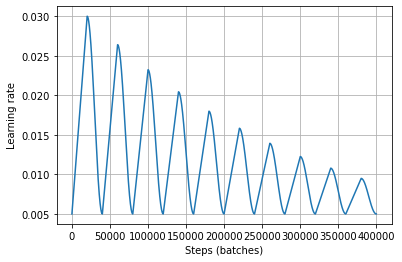

In [20]:
lrs = []
for i in range(n_steps):
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
plt.plot(list(range(len(lrs))), lrs)
plt.grid()
plt.xlabel('Steps (batches)')
plt.ylabel('Learning rate')

## Make a learning rate scheduler (warm start)
* Used in the `Attention is all you need paper`

In [38]:
epochs = 500
n_steps = epochs*n_batches
n_warmup_steps = n_batches*50
print('Total number of batches(steps):{}'.format(n_steps))
criterion = nn.CrossEntropyLoss()
lr = 0.03
optimizer = optim.SGD(sentiment_trf.parameters(), lr=lr, momentum=0.9)
scheduled_optimizer = ScheduledOptim(optimizer, 50.0, d_model, n_warmup_steps) 

Total number of batches(steps):400000


### Visualize the scheduler

Text(0, 0.5, 'Learning rate')

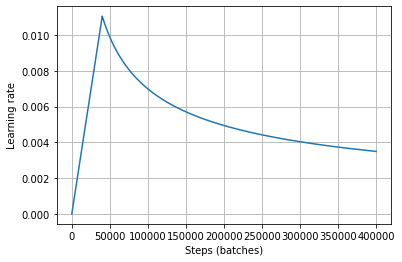

In [39]:
lrs = []
for i in range(n_steps):
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduled_optimizer.update_lr()
lrs = lrs[1:]
plt.plot(list(range(len(lrs))), lrs)
plt.grid()
plt.xlabel('Steps (batches)')
plt.ylabel('Learning rate')

## Re-start the scheduler

In [30]:
classifier_type = 'learnable_pooling'

In [25]:
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=first_cycle_steps, cycle_mult=1.0, 
                                          max_lr=lr, min_lr=min_lr, warmup_steps=warmup_steps, gamma=gamma)

## Save checkpoint

In [34]:
PATH = './imdb_net_{}_sgd_lr_{}_gamma_{}_{}_epochs_{}_batch.pth'.format(classifier_type, lr, gamma, 
                                                                           epochs, batch_size)
print('Checkpoints will be saved to:{}'.format(PATH))
def save_checkpoint(model, path):
    print('Saved checkpoint to:{}'.format(path))
    torch.save(model.state_dict(), path)

Checkpoints will be saved to:./imdb_net_learnable_pooling_sgd_lr_0.00599875_gamma_0.88_500_epochs_32_batch.pth


## Testing function

In [26]:
def test_accuracy():
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_iterator:
            texts, labels = data.text.transpose(0,1).to(device), data.label.to(device)
            # calculate outputs by running images through the network
            outputs = sentiment_trf(texts)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the {} test sentences:{}'.format(total, accuracy))
    return accuracy

In [41]:
data.text.shape

torch.Size([242, 32])

In [43]:
data.label.shape

torch.Size([32])

## Start the training

In [27]:
test_accuracy()

Accuracy of the network on the 3268 test sentences:50.0


50.0

In [36]:
best_test_accuracy = 0
test_accuracy_history = []
lrs_history = []
train_loss_history = []
for epoch in range(epochs):  # loop over the dataset multiple times
    t1 = time.time()
    running_loss = 0.0
    i = 0
    for data in train_iterator:
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data[0].to(device), data[1].to(device)
        texts, labels = data.text.transpose(0,1).to(device), data.label.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = sentiment_trf(texts)
        #log_prb = F.log_softmax(outputs, dim=1)
        #loss = F.cross_entropy(log_prb, labels, reduction='sum')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #optimizer.step_and_update_lr()

        # print statistics
        running_loss += loss.item()
        if i % n_batches == (n_batches-1):    # print every 2000 mini-batches
            curr_train_loss = running_loss / (n_batches)
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, curr_train_loss))
            train_loss_history.append(curr_train_loss)
            lr = optimizer.param_groups[0]["lr"]
            #lr = optimizer._optimizer.param_groups[0]["lr"]
            lrs_history.append(lr)
            print('Learning rate:{}'.format(lr))
            running_loss = 0.0
        
        if i % (n_batches) == (n_batches-1):
            curr_test_accuracy = test_accuracy()
            test_accuracy_history.append(curr_test_accuracy)
            if(curr_test_accuracy > best_test_accuracy):
                best_test_accuracy = curr_test_accuracy
                save_checkpoint(sentiment_trf, PATH)
        scheduler.step()
        i += 1
        #warmup_scheduler.dampen()
    t2 = time.time()
    print('Time elapsed for epoch:{} is:{}'.format(epoch+1, t2-t1))
print('Finished Training')

[1,   800] loss: 0.542063
Learning rate:0.00799625
Accuracy of the network on the 3268 test sentences:73.77600979192167
Saved checkpoint to:./imdb_net_learnable_pooling_sgd_lr_0.00599875_gamma_0.88_500_epochs_32_batch.pth
Time elapsed for epoch:1 is:163.56228923797607
[2,   800] loss: 0.491933
Learning rate:0.00899625
Accuracy of the network on the 3268 test sentences:73.43941248470013
Time elapsed for epoch:2 is:164.4569706916809
[3,   800] loss: 0.453747
Learning rate:0.00999625
Accuracy of the network on the 3268 test sentences:77.87637698898409
Saved checkpoint to:./imdb_net_learnable_pooling_sgd_lr_0.00599875_gamma_0.88_500_epochs_32_batch.pth
Time elapsed for epoch:3 is:165.4962282180786
[4,   800] loss: 0.401920
Learning rate:0.010996249999999999
Accuracy of the network on the 3268 test sentences:82.03794369645043
Saved checkpoint to:./imdb_net_learnable_pooling_sgd_lr_0.00599875_gamma_0.88_500_epochs_32_batch.pth
Time elapsed for epoch:4 is:165.49088668823242
[5,   800] loss: 0

[39,   800] loss: 0.010791
Learning rate:0.012183089317472973
Accuracy of the network on the 3268 test sentences:87.02570379436965
Saved checkpoint to:./imdb_net_learnable_pooling_sgd_lr_0.00599875_gamma_0.88_500_epochs_32_batch.pth
Time elapsed for epoch:39 is:168.93146419525146
[40,   800] loss: 0.007906
Learning rate:0.010807139308274451
Accuracy of the network on the 3268 test sentences:86.90330477356181
Time elapsed for epoch:40 is:166.8956298828125
[41,   800] loss: 0.006342
Learning rate:0.009536739710305619
Accuracy of the network on the 3268 test sentences:86.78090575275398
Time elapsed for epoch:41 is:165.31841254234314
[42,   800] loss: 0.005960
Learning rate:0.008391925484126386
Accuracy of the network on the 3268 test sentences:86.87270501835985
Time elapsed for epoch:42 is:165.41787362098694
[43,   800] loss: 0.004494
Learning rate:0.007390751033962464
Accuracy of the network on the 3268 test sentences:87.08690330477356
Saved checkpoint to:./imdb_net_learnable_pooling_sgd

[84,   800] loss: 0.013832
Learning rate:0.017709932787253913
Accuracy of the network on the 3268 test sentences:85.83231334149326
Time elapsed for epoch:84 is:164.5293517112732
[85,   800] loss: 0.007551
Learning rate:0.016376890790647074
Accuracy of the network on the 3268 test sentences:86.10771113831089
Time elapsed for epoch:85 is:164.78696012496948
[86,   800] loss: 0.007889
Learning rate:0.015033173821916778
Accuracy of the network on the 3268 test sentences:85.70991432068543
Time elapsed for epoch:86 is:165.16379284858704
[87,   800] loss: 0.007032
Learning rate:0.0136999731003575
Accuracy of the network on the 3268 test sentences:86.81150550795594
Time elapsed for epoch:87 is:165.81852650642395
[88,   800] loss: 0.006086
Learning rate:0.01239831399776374
Accuracy of the network on the 3268 test sentences:86.44430844553244
Time elapsed for epoch:88 is:165.0767629146576
[89,   800] loss: 0.005363
Learning rate:0.011148724455756865
Accuracy of the network on the 3268 test sentenc

[130,   800] loss: 0.009854
Learning rate:0.019930066426657657
Accuracy of the network on the 3268 test sentences:85.77111383108935
Time elapsed for epoch:130 is:164.21551084518433
[131,   800] loss: 0.010185
Learning rate:0.019004223596092062
Accuracy of the network on the 3268 test sentences:86.78090575275398
Time elapsed for epoch:131 is:164.59310817718506
[132,   800] loss: 0.008185
Learning rate:0.01800129055933286
Accuracy of the network on the 3268 test sentences:86.75030599755202
Time elapsed for epoch:132 is:164.8053252696991
[133,   800] loss: 0.008625
Learning rate:0.016937084169492904
Accuracy of the network on the 3268 test sentences:86.59730722154222
Time elapsed for epoch:133 is:164.64333176612854
[134,   800] loss: 0.008160
Learning rate:0.015828387597066042
Accuracy of the network on the 3268 test sentences:86.81150550795594
Time elapsed for epoch:134 is:164.71956491470337
[135,   800] loss: 0.005647
Learning rate:0.014692685649302685
Accuracy of the network on the 326

[176,   800] loss: 0.007194
Learning rate:0.019903227193707535
Accuracy of the network on the 3268 test sentences:86.29130966952265
Time elapsed for epoch:176 is:164.47524905204773
[177,   800] loss: 0.005587
Learning rate:0.019490742611285725
Accuracy of the network on the 3268 test sentences:86.81150550795594
Time elapsed for epoch:177 is:164.91408514976501
[178,   800] loss: 0.007794
Learning rate:0.018971512176080882
Accuracy of the network on the 3268 test sentences:85.86291309669522
Time elapsed for epoch:178 is:164.46286964416504
[179,   800] loss: 0.006041
Learning rate:0.01835372446222942
Accuracy of the network on the 3268 test sentences:86.16891064871481
Time elapsed for epoch:179 is:164.608957529068
[180,   800] loss: 0.005458
Learning rate:0.017647122351027264
Accuracy of the network on the 3268 test sentences:86.65850673194615
Time elapsed for epoch:180 is:164.537371635437
[181,   800] loss: 0.004069
Learning rate:0.01686284937987172
Accuracy of the network on the 3268 te

Accuracy of the network on the 3268 test sentences:87.23990208078335
Time elapsed for epoch:221 is:165.50532150268555
[222,   800] loss: 0.001786
Learning rate:0.01746927773888
Accuracy of the network on the 3268 test sentences:86.59730722154222
Time elapsed for epoch:222 is:165.225923538208
[223,   800] loss: 0.004101
Learning rate:0.01798891217088
Accuracy of the network on the 3268 test sentences:86.99510403916769
Time elapsed for epoch:223 is:164.69884991645813
[224,   800] loss: 0.005005
Learning rate:0.017940025308097723
Accuracy of the network on the 3268 test sentences:86.35250917992656
Time elapsed for epoch:224 is:164.648859500885
[225,   800] loss: 0.002850
Learning rate:0.017787555425887783
Accuracy of the network on the 3268 test sentences:87.08690330477356
Time elapsed for epoch:225 is:164.48908686637878
[226,   800] loss: 0.003929
Learning rate:0.017535854973286295
Accuracy of the network on the 3268 test sentences:86.44430844553244
Time elapsed for epoch:226 is:164.4388

[267,   800] loss: 0.001044
Learning rate:0.013230662909414399
Accuracy of the network on the 3268 test sentences:86.44430844553244
Time elapsed for epoch:267 is:165.55158925056458
[268,   800] loss: 0.000691
Learning rate:0.013663941209574398
Accuracy of the network on the 3268 test sentences:87.27050183598531
Time elapsed for epoch:268 is:164.79097986221313
[269,   800] loss: 0.000404
Learning rate:0.014097219509734398
Accuracy of the network on the 3268 test sentences:87.02570379436965
Time elapsed for epoch:269 is:164.67492246627808
[270,   800] loss: 0.000938
Learning rate:0.014530497809894398
Accuracy of the network on the 3268 test sentences:87.08690330477356
Time elapsed for epoch:270 is:165.00139546394348
[271,   800] loss: 0.001277
Learning rate:0.014963776110054398
Accuracy of the network on the 3268 test sentences:87.57649938800489
Time elapsed for epoch:271 is:164.581303358078
[272,   800] loss: 0.000520
Learning rate:0.015397054410214397
Accuracy of the network on the 326

Time elapsed for epoch:311 is:164.84223985671997
[312,   800] loss: 0.001222
Learning rate:0.010000648839580671
Accuracy of the network on the 3268 test sentences:87.11750305997552
Time elapsed for epoch:312 is:165.18162608146667
[313,   800] loss: 0.000460
Learning rate:0.010357933743721471
Accuracy of the network on the 3268 test sentences:87.91309669522644
Time elapsed for epoch:313 is:165.4921748638153
[314,   800] loss: 0.000190
Learning rate:0.010715218647862271
Accuracy of the network on the 3268 test sentences:86.96450428396572
Time elapsed for epoch:314 is:165.4218590259552
[315,   800] loss: 0.000053
Learning rate:0.011072503552003071
Accuracy of the network on the 3268 test sentences:87.20930232558139
Time elapsed for epoch:315 is:165.25895810127258
[316,   800] loss: 0.000192
Learning rate:0.01142978845614387
Accuracy of the network on the 3268 test sentences:87.36230110159119
Time elapsed for epoch:316 is:165.21786761283875
[317,   800] loss: 0.000185
Learning rate:0.01178

[357,   800] loss: 0.000323
Learning rate:0.0076126074006114715
Accuracy of the network on the 3268 test sentences:88.49449204406365
Saved checkpoint to:./imdb_net_learnable_pooling_sgd_lr_0.00599875_gamma_0.88_500_epochs_32_batch.pth
Time elapsed for epoch:357 is:165.21386861801147
[358,   800] loss: 0.000061
Learning rate:0.007903018116255375
Accuracy of the network on the 3268 test sentences:88.06609547123622
Time elapsed for epoch:358 is:165.10788297653198
[359,   800] loss: 0.000130
Learning rate:0.00819342883189928
Accuracy of the network on the 3268 test sentences:87.60709914320685
Time elapsed for epoch:359 is:165.53601026535034
[360,   800] loss: 0.000061
Learning rate:0.008483839547543183
Accuracy of the network on the 3268 test sentences:87.23990208078335
Time elapsed for epoch:360 is:165.43116545677185
[361,   800] loss: 0.000028
Learning rate:0.008774250263187088
Accuracy of the network on the 3268 test sentences:87.60709914320685
Time elapsed for epoch:361 is:165.12165665

[402,   800] loss: 0.000631
Learning rate:0.005925377363704918
Accuracy of the network on the 3268 test sentences:87.97429620563035
Time elapsed for epoch:402 is:164.93875527381897
[403,   800] loss: 0.000078
Learning rate:0.006156938793471553
Accuracy of the network on the 3268 test sentences:86.96450428396572
Time elapsed for epoch:403 is:164.56882333755493
[404,   800] loss: 0.000459
Learning rate:0.006388500223238188
Accuracy of the network on the 3268 test sentences:87.94369645042839
Time elapsed for epoch:404 is:164.9343957901001
[405,   800] loss: 0.000178
Learning rate:0.006620061653004824
Accuracy of the network on the 3268 test sentences:87.69889840881272
Time elapsed for epoch:405 is:164.54396080970764
[406,   800] loss: 0.000144
Learning rate:0.006851623082771459
Accuracy of the network on the 3268 test sentences:87.82129742962056
Time elapsed for epoch:406 is:164.84993934631348
[407,   800] loss: 0.000044
Learning rate:0.007083184512538095
Accuracy of the network on the 32

Accuracy of the network on the 3268 test sentences:87.05630354957161
Time elapsed for epoch:447 is:165.1668083667755
[448,   800] loss: 0.000076
Learning rate:0.00500000032138714
Accuracy of the network on the 3268 test sentences:87.91309669522644
Time elapsed for epoch:448 is:165.03338193893433
[449,   800] loss: 0.000012
Learning rate:0.0051790999054764095
Accuracy of the network on the 3268 test sentences:87.45410036719706
Time elapsed for epoch:449 is:165.21002388000488
[450,   800] loss: 0.000676
Learning rate:0.0053588739636710485
Accuracy of the network on the 3268 test sentences:87.85189718482252
Time elapsed for epoch:450 is:164.7052686214447
[451,   800] loss: 0.000105
Learning rate:0.005538648021865688
Accuracy of the network on the 3268 test sentences:88.00489596083231
Time elapsed for epoch:451 is:164.97900915145874
[452,   800] loss: 0.000249
Learning rate:0.005718422080060327
Accuracy of the network on the 3268 test sentences:87.57649938800489
Time elapsed for epoch:452 

Accuracy of the network on the 3268 test sentences:87.97429620563035
Time elapsed for epoch:492 is:165.53404545783997
[493,   800] loss: 0.000043
Learning rate:0.005429795015508462
Accuracy of the network on the 3268 test sentences:87.27050183598531
Time elapsed for epoch:493 is:166.05896973609924
[494,   800] loss: 0.000125
Learning rate:0.00527847100111937
Accuracy of the network on the 3268 test sentences:87.76009791921665
Time elapsed for epoch:494 is:165.83822894096375
[495,   800] loss: 0.000049
Learning rate:0.005158194636311443
Accuracy of the network on the 3268 test sentences:87.72949816401469
Time elapsed for epoch:495 is:165.46996188163757
[496,   800] loss: 0.000008
Learning rate:0.005070862751207318
Accuracy of the network on the 3268 test sentences:87.76009791921665
Time elapsed for epoch:496 is:165.93262338638306
[497,   800] loss: 0.000104
Learning rate:0.005017852621804628
Accuracy of the network on the 3268 test sentences:87.91309669522644
Time elapsed for epoch:497 

In [37]:
print('Best test accuracy is:{}'.format(best_test_accuracy))

Best test accuracy is:88.73929008567931


## Analyze the test accuracy

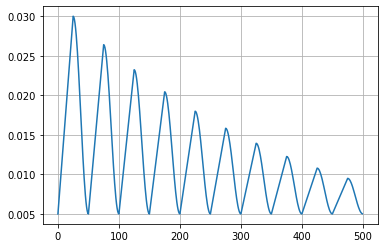

In [38]:
plt.plot(list(range(len(lrs[0::n_batches]))), lrs[0::n_batches])
plt.grid()

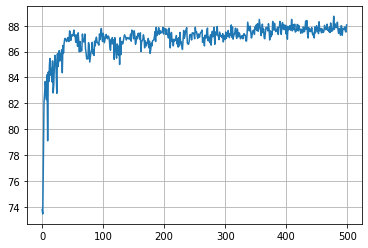

In [39]:
plt.plot(list(range(len(test_accuracy_history))), test_accuracy_history)
plt.grid()